In [1]:
# common imports
import numpy as np
import pandas as pd
import os, cv2
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

# global variables
ROWS = 200
COLUMNS = 200
CHANNELS = 3
CLASSES = {0: 'cat', 1: 'dog'}

# display setup
sns.set(style="whitegrid")  # for plots

# Preface
* Dogs vs. Cats is a dataset containing 25,000 samples.
* Each sample is a colored image (JPEG file) of a dog or a cat. The image sizes vary, so they need to be scaled to the same size.
* The data contains two labels (mentioned in each image file's name), making this a **binary classification** problem.
In other words, this is a **supervised learning** task.
* The model will be trained using all available data and run without learning anymore. This method is named **offline/batch learning**.
* Main objective: Find the best algorithm and model parameters that classify the unused images correctly.


# 1. Getting the Data

In [2]:
train_path = r"dogs-vs-cats\train/"

train_images = [train_path + i for i in os.listdir(train_path)]
# listdir returns a list with the file names in the given directory

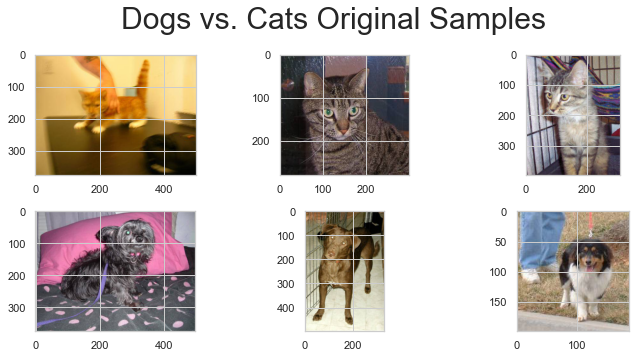

In [3]:
fig = plt.figure(figsize=(10,7))

for i in range(6):
    plt.subplot(330+i+1)
    if i < 3:
        filename = train_path + 'cat.' + str(i) + '.jpg'
    else:
        filename = train_path + 'dog.' + str(i-3) + '.jpg'
    image = cv2.imread(filename)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
fig.suptitle("Dogs vs. Cats Original Samples", size=30)
plt.tight_layout()
plt.show()

In [4]:
def image_shape(image_path):
    return cv2.imread(image_path).shape

def load_data_shapes(image_file_names):
    shapes = []
    for i, image_file in enumerate(image_file_names):
        shapes.append(image_shape(image_file))
    return shapes

In [5]:
image_shapes = load_data_shapes(train_images)

In [6]:
image_res_df = pd.DataFrame(image_shapes, columns=['height', 'width', 'n_channels'])
image_res_df.head(3)

,height,width,n_channels
0,374,500,3
1,280,300,3
2,499,489,3


In [7]:
image_res_df.n_channels.unique()

array([3], dtype=int64)

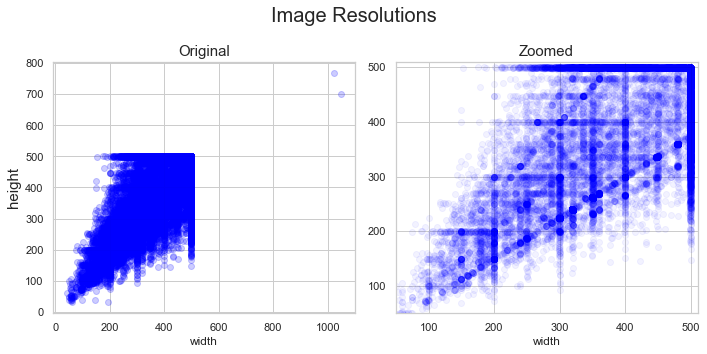

In [8]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,5))
ax1.scatter(image_res_df.width, image_res_df.height, color='blue', alpha=0.2)
ax1.set_title("Original", size=15)
points = ax2.scatter(image_res_df.width, image_res_df.height, color='blue', alpha=0.05)
ax1.set_xlabel("width")
ax1.set_ylabel("height", size = 15)
ax2.set_xlim(xmin=50, xmax=510)
ax2.set_ylim(ymin=50, ymax=510)
ax2.set_title("Zoomed", size=15)
ax2.set_xlabel("width")
fig.suptitle("Image Resolutions", size=20)
plt.tight_layout()
plt.show()

> Observations:
>> * Most image resolutions are less than 500 by 500. There is also a fair amount around 400x400,
>> 300x300, and 200x200.
>> * Rescaling the images to 200x200 seems to be the best option for maintainable amount of features
>> that also reflects the data.
>> * After rescaling, the number of features will be 200x200x3 = 120,000.
>
> Note: The global variables (instantiated below the imports) have been set to these values.

> Why was this necessary?
>
> In order to use the data for ML algorithms, all images need to be processed into an array containing the same pixel values.
> The following functions do just that:

In [11]:
def read_resize_img(file_path):
    img = cv2.imread(file_path, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return cv2.resize(img, (ROWS, COLUMNS), interpolation=cv2.INTER_CUBIC)


def prep_data(images):
    m = len(images)
    n_pixels = ROWS * COLUMNS * CHANNELS
    X = np.ndarray((m, n_pixels), dtype=np.uint8)
    y = np.zeros((m, 1))
    path = []

# enumerate() function iterates the input object ('images') by using two variables:
# i is the count of the current iteration
# img_file is the path of the image file at the current iteration
    for i, img_file in enumerate(images):
        img = read_resize_img(img_file)
        X[i, :] = np.squeeze(img.reshape((n_pixels, 1))) # squeeze removes useless one-dimensional arrays
        path.append(img_file)

        if '/dog' in img_file:
            y[i, 0] = 1
        elif '/cat' in img_file:
            y[i, 0] = 0
        else: # if needed for the test set on kaggle (each image has an id instead of a class)
            y[i, 0] = img_file.split('/')[-1].split('.')[0]
        if i % 5000 == 0:
            print("Loading: {}/{}".format(i, m))  # print loading progress
    print("Finished Loading Data")
    return X, y, path

In [12]:
X, labels, path = prep_data(train_images)

Loading: 0/25000
Loading: 5000/25000
Loading: 10000/25000
Loading: 15000/25000
Loading: 20000/25000
Finished Loading Data


In [13]:
X

array([[203, 164,  87, ...,   1,   1,   0],
       [ 39,  44,  40, ...,  43,  32,  23],
       [ 28,  32,  41, ..., 170, 165,   2],
       ...,
       [ 52,  47,  44, ..., 189, 147, 107],
       [253, 255, 252, ..., 130, 114, 115],
       [245, 238, 228, ..., 254, 254, 254]], dtype=uint8)

In [14]:
labels

array([[0.],
       [0.],
       [0.],
       ...,
       [1.],
       [1.],
       [1.]])

In [15]:
path

['dogs-vs-cats\\train/cat.0.jpg',
 'dogs-vs-cats\\train/cat.1.jpg',
 'dogs-vs-cats\\train/cat.10.jpg',
 'dogs-vs-cats\\train/cat.100.jpg',
 'dogs-vs-cats\\train/cat.1000.jpg',
 'dogs-vs-cats\\train/cat.10000.jpg',
 'dogs-vs-cats\\train/cat.10001.jpg',
 'dogs-vs-cats\\train/cat.10002.jpg',
 'dogs-vs-cats\\train/cat.10003.jpg',
 'dogs-vs-cats\\train/cat.10004.jpg',
 'dogs-vs-cats\\train/cat.10005.jpg',
 'dogs-vs-cats\\train/cat.10006.jpg',
 'dogs-vs-cats\\train/cat.10007.jpg',
 'dogs-vs-cats\\train/cat.10008.jpg',
 'dogs-vs-cats\\train/cat.10009.jpg',
 'dogs-vs-cats\\train/cat.1001.jpg',
 'dogs-vs-cats\\train/cat.10010.jpg',
 'dogs-vs-cats\\train/cat.10011.jpg',
 'dogs-vs-cats\\train/cat.10012.jpg',
 'dogs-vs-cats\\train/cat.10013.jpg',
 'dogs-vs-cats\\train/cat.10014.jpg',
 'dogs-vs-cats\\train/cat.10015.jpg',
 'dogs-vs-cats\\train/cat.10016.jpg',
 'dogs-vs-cats\\train/cat.10017.jpg',
 'dogs-vs-cats\\train/cat.10018.jpg',
 'dogs-vs-cats\\train/cat.10019.jpg',
 'dogs-vs-cats\\train/cat.1

In [16]:
# create a DataFrame including a column for labels
df = pd.concat([pd.DataFrame(path, columns=['path']), pd.DataFrame(labels, columns=['label']), pd.DataFrame(X)], axis=1)
df.head()

,path,label,0,1,2,3,4,5,6,7,...,119990,119991,119992,119993,119994,119995,119996,119997,119998,119999
0,dogs-vs-cats\train/cat.0.jpg,0.0,203,164,87,206,167,90,210,171,...,0,1,1,0,1,1,0,1,1,0
1,dogs-vs-cats\train/cat.1.jpg,0.0,39,44,40,40,44,42,41,45,...,31,55,42,34,48,35,27,43,32,23
2,dogs-vs-cats\train/cat.10.jpg,0.0,28,32,41,15,19,28,7,11,...,4,191,190,6,181,178,4,170,165,2
3,dogs-vs-cats\train/cat.100.jpg,0.0,222,223,218,223,224,219,223,224,...,208,214,211,205,217,212,208,217,211,211
4,dogs-vs-cats\train/cat.1000.jpg,0.0,140,112,75,140,112,75,141,113,...,70,101,89,62,91,79,55,89,77,55


In [17]:
# check if all values are in DataFrame, merely a precaution after this data processing
# np.isnan checks if the element is is not a number
# df.values returns a numpy array containing the data without index or column names
# (like X shown above with an additional value in each row for the label)
# sum() returns the absolute amount missing
np.isnan(df.values).sum()

MemoryError: Unable to allocate 22.4 GiB for an array with shape (120000, 25000) and data type object

In [ ]:
def show_images(X, y, index):
    image = X[index]
    image = image.reshape((ROWS, COLUMNS, CHANNELS))
    plt.figure(figsize=(6, 3))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title("This is a {}".format(CLASSES[y[index, 0]]))
    plt.axis('off')
    plt.show()

In [ ]:
# for i in range(11):
   # show_images(X, labels, i)

In [ ]:
# use groupby to locate instances for each label
label_groups = df.groupby('label')

In [ ]:
# 3 cat image samples
sample0 = label_groups.get_group(0)[:3].drop('label', axis = 1)
sample0

In [ ]:
# 3 dog image samples
sample1 = label_groups.get_group(1)[:3].drop('label', axis = 1)
sample1

In [ ]:
df['label'].value_counts()

> Observations:
>> * By looking at the index numbers for each group, the first instance labeled 1 (dog) is located at index 12500.
>> My assumption was that all cat images were the first 12,500 samples, with the rest as dogs.
>> To validate my assumptions I counted the values for each class.
>> * Why is this important? Data arranged by class order could result in poor performance of the ML algorithms,
>> an unrepresentative test set or cross-validation folds later on (i.e., a test set containing only cat images).
>> * Solution: The train_test_split() is a random sampling method, so it takes care of this.
>> The random_state parameter ensures that the generated shuffled split is the same each time.
>

In [ ]:
# combine cat and dog samples as one DataFrame
sample_images = pd.concat([sample0, sample1], ignore_index=True)

In [ ]:
fig = plt.figure(figsize=(10,7))
rows = 2
columns = 3

# add sample image in each iteration
for i in range(rows*columns):
    image = sample_images[i:i+1].to_numpy().reshape((ROWS, COLUMNS, CHANNELS))
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(image)
    plt.axis('off')
fig.suptitle("Dogs vs. Cats Resized Samples", size=30)
plt.tight_layout()
plt.show()

> ### Splitting the Data:
>> Before further analysis let's split the data into a training set and a testing set.
>> This will ensure avoidance of bias that could occur from learning the data as a whole.

In [ ]:
train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)